In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import scvelo as scv
from dataloaders import *

In [2]:

# Autoencoder Model Definition (same as before)
class GeodesicAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims):
        super(GeodesicAutoencoder, self).__init__()
        
        # Encoder
        encoder_layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            in_dim = h_dim
        encoder_layers.append(nn.Linear(in_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = []
        in_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(in_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            in_dim = h_dim
        decoder_layers.append(nn.Linear(in_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed


# Geodesic Distance Loss (same as before)
# Geodesic Distance Loss
def geodesic_distance_loss(latent, geodesic_distances, batch_indices, k=5):
    # Get the pairwise distances in the latent space for the current batch
    pairwise_distances = torch.cdist(latent, latent, p=2)
    
    # Slice the geodesic distances to get the relevant subset for the batch
    batch_geodesic_distances = geodesic_distances[batch_indices, :][:, batch_indices]

    # Create a mask for the nearest neighbors based on geodesic distances
    geodesic_mask = torch.topk(batch_geodesic_distances, k=k, dim=-1, largest=False)[1]
    geodesic_mask = torch.zeros_like(batch_geodesic_distances).scatter_(1, geodesic_mask, 1.0)

    # Compute the loss
    loss = geodesic_mask * (pairwise_distances - batch_geodesic_distances) ** 2
    return loss.mean()


# Training function with geodesic distance preservation
# Training function with geodesic distance preservation
def train_geodesic_autoencoder(model, data_loader, geodesic_distances, epochs=100, lr=1e-3, lambda_geo=1.0):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # Reconstruction loss
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_data, batch_indices in data_loader:
            optimizer.zero_grad()

            # Forward pass
            latent, reconstructed = model(batch_data)
            
            # Compute losses
            reconstruction_loss = criterion(reconstructed, batch_data)
            
            # Compute geodesic distance loss (here, we pass the batch's indices and distances)
            geodesic_loss = geodesic_distance_loss(latent, geodesic_distances, batch_indices)
            
            # Total loss
            loss = reconstruction_loss + lambda_geo * geodesic_loss
            #loss = lambda_geo * geodesic_loss
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Lambda Geo Loss: {lambda_geo * geodesic_loss.item():.4f}")



In [3]:

# Save Latent Variables in adata.obsm["z"]
def save_latent_variables(model, data_loader, adata):
    model.eval()  # Set model to evaluation mode
    all_latents = []
    
    with torch.no_grad():
        for batch_data, _ in data_loader:
            latent, _ = model(batch_data)
            all_latents.append(latent)
    
    # Concatenate all latent variables and save to adata.obsm["z"]
    all_latents = torch.cat(all_latents, dim=0).numpy()  # Convert to NumPy array
    adata.obsm["z"] = all_latents
    print(f"Latent variables saved to adata.obsm['z'] with shape: {adata.obsm['z'].shape}")


In [4]:


# Example Usage
if __name__ == "__main__":
    # Load AnnData (Example)
    adata = scv.datasets.pancreas()
    adata.layers["unspliced_counts"] = adata.layers["unspliced"]
    adata.layers["spliced_counts"] = adata.layers["spliced"]
    adata.X = adata.layers["spliced_counts"]
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=4000)
    scv.pp.moments(adata, n_neighbors=200)
    
    # Setup DataLoader
    batch_size = adata.shape[0]
    _, _, full_data_loader = setup_dataloaders(adata, batch_size)
    
    # Compute geodesic distances for training
    #data = np.concatenate([adata.layers["unspliced"].toarray(), adata.layers["spliced"].toarray()], axis=1)
    data = adata.layers["spliced_counts"].toarray()
    k = 10
    knn_graph = kneighbors_graph(data, n_neighbors=k, mode="distance", include_self=False)
    geodesic_distances = np.asarray(knn_graph.toarray())
    
    # Normalize geodesic distances
    geodesic_distances[geodesic_distances == 0] = np.inf  # Set disconnected pairs to infinity
    geodesic_distances = np.nan_to_num(1 / geodesic_distances)  # Invert distances
    geodesic_distances_tensor = torch.tensor(geodesic_distances, dtype=torch.float32)
    
    # Define Model
    input_dim = data.shape[1]*2
    latent_dim = 32
    hidden_dims = [512,256,128,64]
    model = GeodesicAutoencoder(input_dim, latent_dim, hidden_dims)


    epochs=100
    lr=1e-3
    lambda_geo=100
    
    # Train the model
    train_geodesic_autoencoder(
        model,
        full_data_loader,
        geodesic_distances_tensor,
        epochs=epochs,
        lr=lr,
        lambda_geo=lambda_geo
    )

    save_latent_variables(model, full_data_loader, adata)


Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 4000 highly variable genes.
Logarithmized X.
computing neighbors


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
number of training observations: 2956
number of test observations: 740
Epoch 1/100, Loss: 108.6958, Lambda Geo Loss: 0.0216
Epoch 2/100, Loss: 82.0750, Lambda Geo Loss: 0.0412
Epoch 3/100, Loss: 56.4458, Lambda Geo Loss: 0.0243
Epoch 4/100, Loss: 51.0930, Lambda Geo Loss: 0.0072
Epoch 5/100, Loss: 49.8436, Lambda Geo Loss: 0.0156
Epoch 6/100, Loss: 49.7090, Lambda Geo Loss: 0.0336
Epoch 7/100, Loss: 49.7625, Lambda Geo Loss: 0.0381
Epoch 8/100, Loss: 49.6588, Lambda Geo Loss: 0.0130
Epoch 9/100, Loss: 49.5766, Lambda Geo Loss: 0.0103
Epoch 10/100, Loss: 49.5819, Lambda Geo Loss: 0.0109
Epoch 11/100, Loss: 49.5535, Lambda Geo Loss: 0.0113
Epoch 12/100, Loss: 49.5183, Lambda Geo Loss: 0.0149
Epoch 13/100, Loss: 49.4998, Lambda Geo Loss:

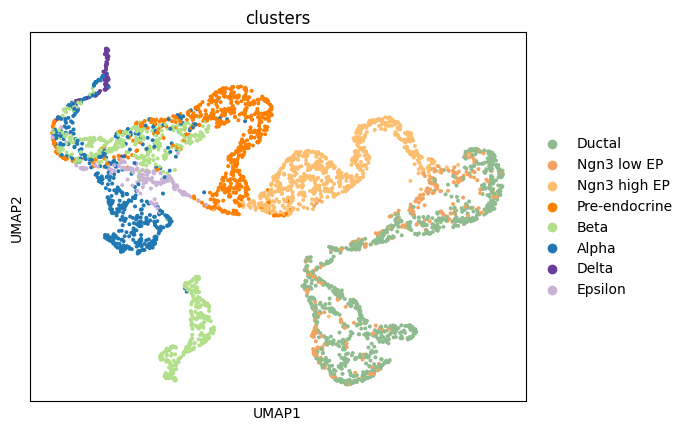

In [5]:
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata)
sc.pl.umap(adata, color="clusters")

In [ ]:
def save_embedding(bool):
    if bool:
        import os
        # Save parameters as a single-line string for a filename
        parameters_filename = f"n_neighbors-{k}_batch_size-{batch_size}_input_dim-{input_dim}_latent_dim-{latent_dim}_hidden_dims-{hidden_dims}_epochs-{epochs}_lr-1e3_lambda_geo-10.0".replace(" ", "").replace(",", "-").replace("[", "").replace("]", "")
        print(parameters_filename)
        filename = os.path.join("embeddings", parameters_filename)
        np.save(filename, adata.obsm["z"])

save_embedding(False)